# Plot Training Loss History of Cavity Problem

We already saved the training loss history in the saved checkpoints.


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
import os
import torch
import numpy as np


Import local packages


In [4]:
from src.utils.logger import Logging
from src.utils.plot_loss import plot_loss_history
from src.utils.color import model_color

Set various constant variables: model path, name, etc. We choose the best performing models from each architecture.


In [5]:
TEST_DATA_PKL = "./data/cavity.mat"
TEST_CHECKPOINT_PATH = os.path.join("result/cavity")


TANH_NORM_DIST = "./model/a2/cavity_tanh_normal_a2.pth"
TANH_PARAM_DIST = "./model/a1/cavity_tanh_trainable_a1.pth"
BSPLINE_DIST = "./model/a2/cavity_bspline_a2.pth"
GRBF_DIST = "./model/a1/cavity_grbf_a1.pth"
FOURIER_DIST = "./model/a1/cavity_fourier_a1.pth"
CHEBTSHEV_DIST = "./model/a2/cavity_chebyshev_a2.pth"
JACOBI_DIST = "./model/a1/cavity_jacobi_a1.pth"


MODEL_PATH_LIST = {
    "tanh": TANH_NORM_DIST,
    "param_tanh": TANH_PARAM_DIST,
    "grbf": GRBF_DIST,
    "bspline": BSPLINE_DIST,
    "chebyshev": CHEBTSHEV_DIST,
    "jacobi": JACOBI_DIST,
    "fourier": FOURIER_DIST,
}


SOLVER_TO_MODULE = {
    "grbf": "src.nn.grbf",
    "jacobi": "src.nn.jacobi",
    "KAN_BSpline": "src.nn.bspline",
    "KAN_Chebyshev": "src.nn.chebyshev",
    "param_tanh": "src.nn.tanh_parameterized",
    "MLP2": "src.nn.tanh",
    "fourier": "src.nn.fourier",
}

Create logger


In [6]:
logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

## Plot Training Loss History

I saved the training loss in a pickle file during training so that I can plot it later as needed.


### Load Saved Model


In [9]:
state

{'model_state_dict': OrderedDict([('model.layers.0.rbf.grid',
               tensor([-2.0000, -1.4286, -0.8571, -0.2857,  0.2857,  0.8571,  1.4286,  2.0000],
                      device='cuda:0')),
              ('model.layers.0.spline_linear.weight',
               tensor([[ 6.4067e-03, -8.8398e-03, -1.2040e-01,  ...,  1.5991e-01,
                        -4.1444e-01, -9.2954e-01],
                       [-2.5066e-03, -5.8859e-01, -4.3515e-01,  ...,  5.6400e-03,
                         4.5163e-01,  8.2110e-01],
                       [-6.1724e-04, -2.9080e-01, -1.8968e-01,  ..., -8.5071e-02,
                         3.0479e-01,  7.3705e-01],
                       ...,
                       [ 9.3942e-03, -1.2176e-01, -2.8774e-01,  ...,  1.6679e-01,
                        -1.7023e-01, -5.2959e-01],
                       [ 2.0420e-03, -4.3822e-02, -2.0154e-01,  ...,  9.7576e-02,
                        -7.4234e-01, -1.3782e+00],
                       [ 1.1099e-04,  7.2678e-02, -3.1

In [14]:
all_loss_history = {}

for activation, model_path in MODEL_PATH_LIST.items():
    logger.print(f"MODEL_PATH {model_path}")
    state = torch.load(
        model_path,
    )
    config = state.get("config", {})
    solver = config.get("solver")

    model_activation_name = config.get("activation")
    model_architecture = config.get("network")
    loss_history = state.get("loss_history")
    for lkey, lvalue in loss_history.items():
        logger.print(f"loss: {lkey} , final loss: {lvalue[-1]: .2e}")
    if solver in SOLVER_TO_MODULE:
        module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
        PINNKAN = getattr(module, "PINNKAN")
        model = PINNKAN(model_architecture, model_activation_name).to("cpu")

    model.load_state_dict(state["model_state_dict"])

    logger.print(f"model loaded from {model_path}")
    logger.print(f"problem: {config.get('problem')}")
    logger.print(f"dataset_path:  , {config.get('dataset_path')}")
    logger.print(f"batch size:  , {config.get('batch_size')}")
    logger.print(f"network:  , {config.get('network')}")
    logger.print(f"term loss weights :  , {config.get('weights')}")
    logger.print(f"activation:  , {config.get('activation')}")
    logger.print(f"solver:  , {config.get('solver')}")
    logger.print(
        f"number of iterations:  , {len(loss_history[next(iter(loss_history))])}"
    )
    all_loss_history[activation] = loss_history

INFO:src.utils.logger:MODEL_PATH ./model/a2/cavity_tanh_normal_a2.pth
/tmp/ipykernel_2798/2061887137.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(


Pre-process the loss data for plotting. See the Helmholtz notebook to understand the data structure.


In [15]:
keys = all_loss_history.keys()
values = all_loss_history.values()

model_summed_loss_dict = {}

for model, loss_dict in zip(keys, values):
    total_loss = np.zeros(len(next(iter(loss_dict.values()))))

    print(f"{model=}, #iter={len(total_loss)}")

    for key in loss_dict:
        if key not in ["test"]:
            total_loss += np.array(loss_dict[key])

    model_summed_loss_dict[model] = total_loss

min_length = min([len(x) for x in model_summed_loss_dict.values()])
for key in model_summed_loss_dict:
    model_summed_loss_dict[key] = model_summed_loss_dict[key][0:min_length]

print("Truncated model_summed_loss_dict:", model_summed_loss_dict.keys())
print("Truncated model_summed_loss_dict:", len(model_summed_loss_dict.get("tanh")))

model='tanh', #iter=60001
model='param_tanh', #iter=60001
model='grbf', #iter=60001
model='bspline', #iter=60001
model='chebyshev', #iter=60001
model='jacobi', #iter=60001
model='fourier', #iter=60001
Truncated model_summed_loss_dict: dict_keys(['tanh', 'param_tanh', 'grbf', 'bspline', 'chebyshev', 'jacobi', 'fourier'])
Truncated model_summed_loss_dict: 60001


### Plot Loss History


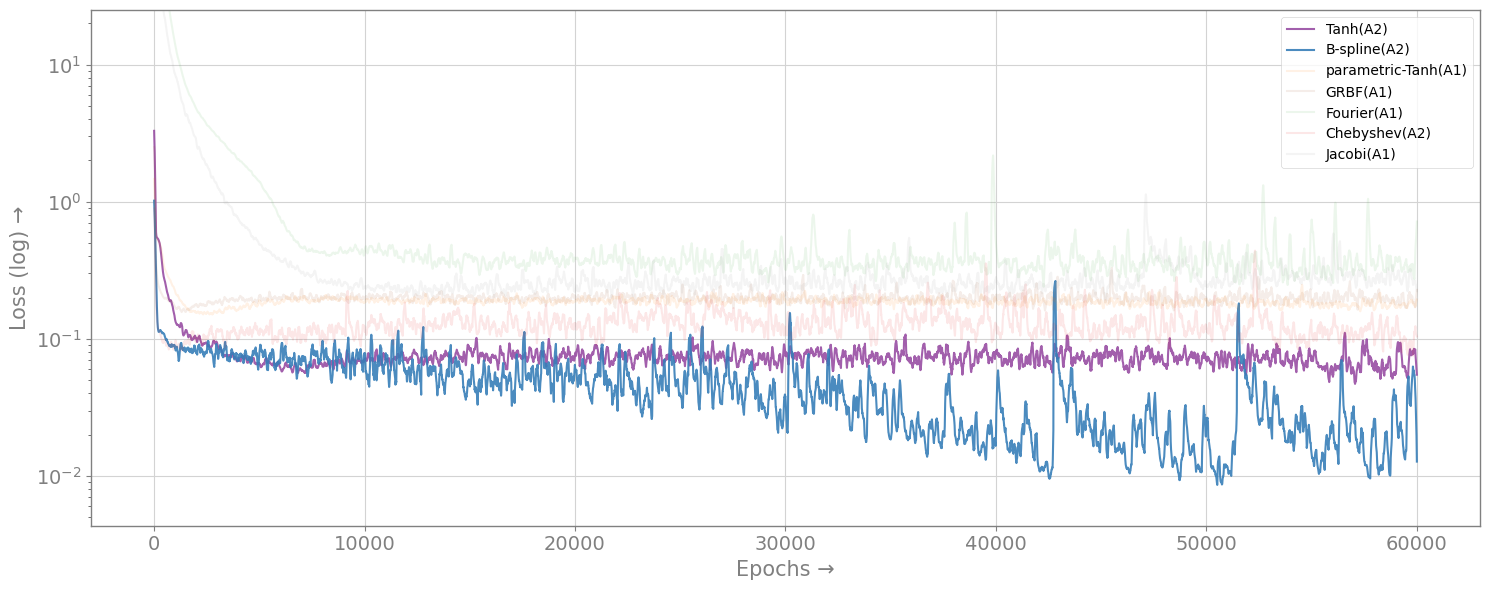

In [19]:
data_list = [
    {
        "data": model_summed_loss_dict["tanh"],
        "color": model_color["tanh"],
        "name": "Tanh(A2)",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["bspline"],
        "color": model_color["bspline"],
        "name": "B-spline(A2)",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["param_tanh"],
        "color": model_color["param_tanh"],
        "name": "parametric-Tanh(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["grbf"],
        "color": model_color["grbf"],
        "name": "GRBF(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["fourier"],
        "color": model_color["fourier"],
        "name": "Fourier(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["chebyshev"],
        "color": model_color["chebyshev"],
        "name": "Chebyshev(A2)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": model_summed_loss_dict["jacobi"],
        "color": model_color["jacobi"],
        "name": "Jacobi(A1)",
        "alpha": 0.1,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_cavity"),
    y_max=25,
)